In [61]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Прогнозирование уровня средней заработной платы в России #

In [62]:
wag = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

Отобразим временной ряд:

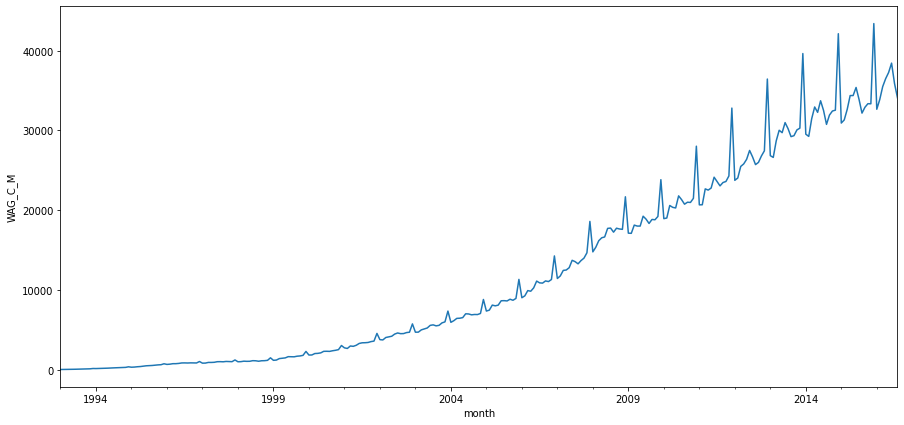

In [63]:
plt.figure(figsize(15,7))
wag.WAG_C_M.plot()
plt.ylabel('WAG_C_M')
pylab.show()

Из графика видим, что у ряда есть явный повышающийся тренд, повышающаяся дисперсия и сезонность. 
Разделим ряд на компоненты и взглянем подробнее

Критерий Дики-Фуллера: p=0.709599


c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1080x720 with 0 Axes>

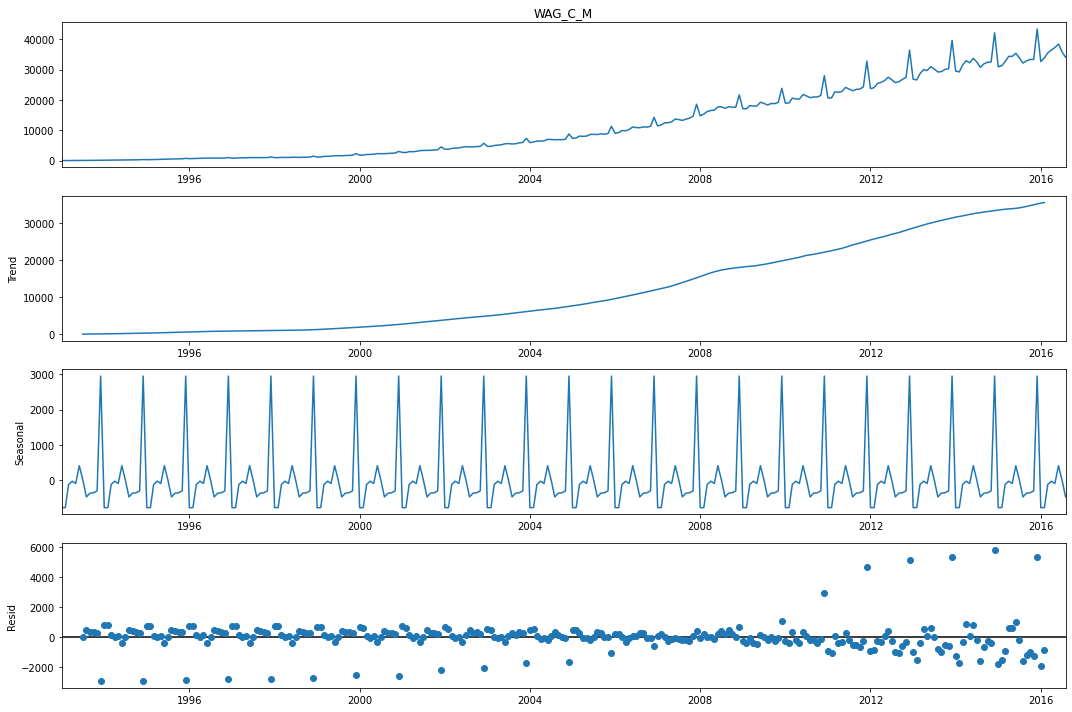

In [64]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.WAG_C_M)[1])

Гипотеза о стационариности ряда уверенно отвергается критерием Дики-Фуллера, это также видно и невооруженным взглядом.

### Стабилизация дисперсии ###

Используем преобразование Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


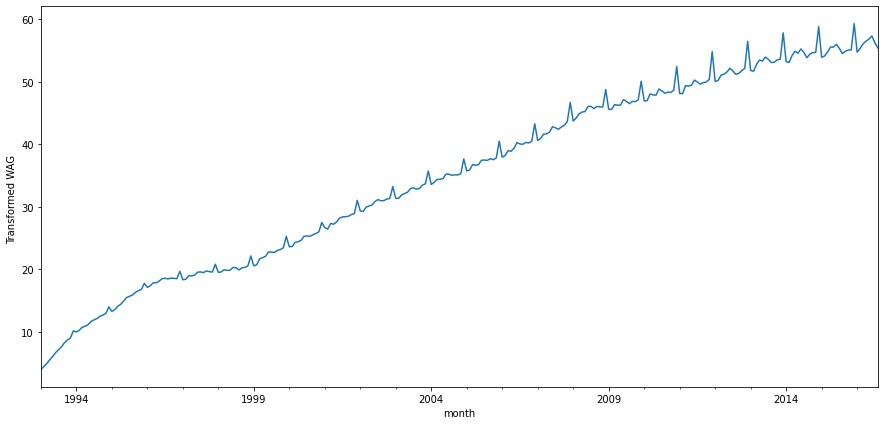

In [65]:
wag['WAG_box'], lmbda = stats.boxcox(wag.WAG_C_M)
plt.figure(figsize(15,7))
wag.WAG_box.plot()
plt.ylabel(u'Transformed WAG ')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.WAG_box)[1])

В результате преобразования дисперсия значительно уменьшилась. Критерий Дики-Фуллера по-прежнему отвергает гипотезу о стационарности ряда

### Сезонность ###

Попробуем провести сезонное дифференцирование, чтобы избавиться от тренда

Критерий Дики-Фуллера: p=0.005639


c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1080x720 with 0 Axes>

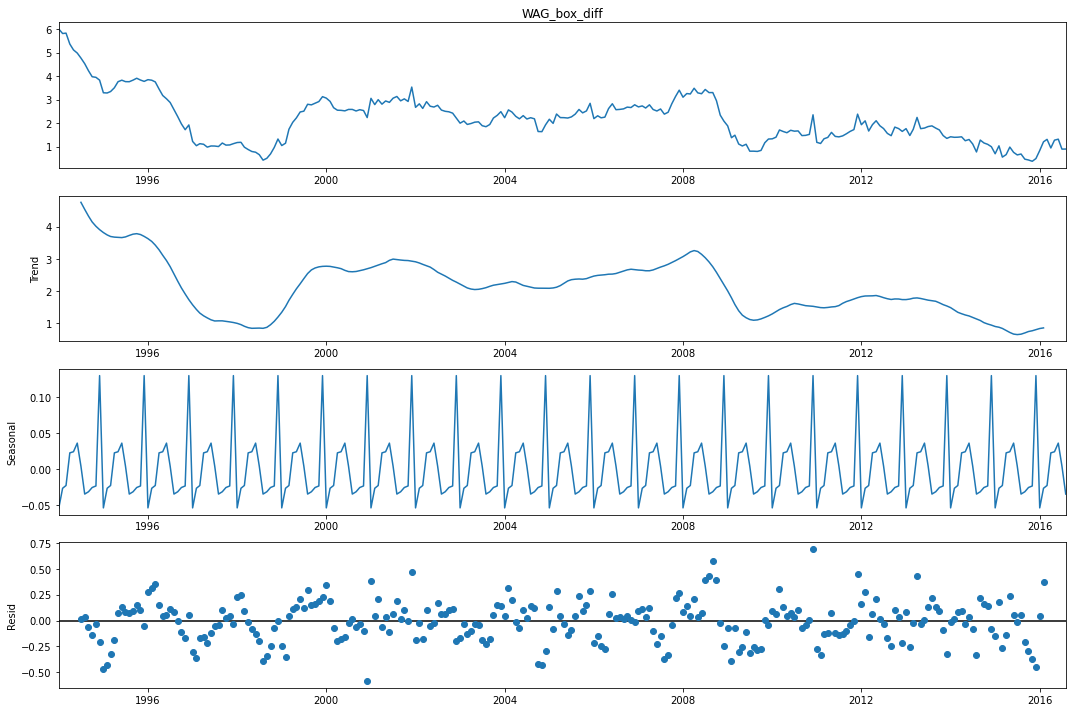

In [66]:
wag['WAG_box_diff'] = wag.WAG_box - wag.WAG_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag.WAG_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.WAG_box_diff[12:])[1])

Тренд значительно изменился, но все таки еще присутствует. Попробуем провести дифференцированние

Критерий Дики-Фуллера: p=0.000000


c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1080x720 with 0 Axes>

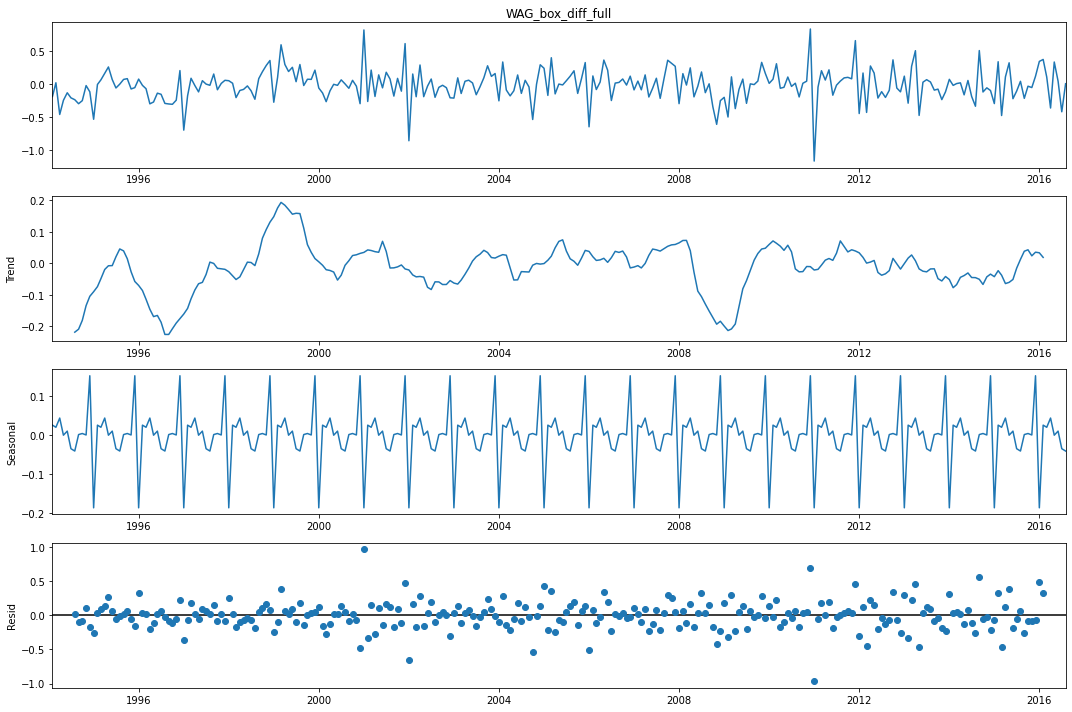

In [67]:
wag['WAG_box_diff_full'] = wag.WAG_box_diff - wag.WAG_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag.WAG_box_diff_full.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.WAG_box_diff_full.dropna())[1])

Отлично! Тренд исчез, а остатки больше похожи на белый шум. Гипотеза о нестационарности ряда уверенно отвергается критерием Дики-Фуллера на уровне значимости 0.0

Таким образом, исходный ряд преобразовываем следующим образом:
- Преобразование Бокса-Кокса с $\lambda = 0.263202$
- Сезонное дифференцирование (S = 12)
- Дифференцирование

### Подбор модели ###

Посмотрим на график функции автокорреляции и частичной автокорреляции полученного ряда

c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


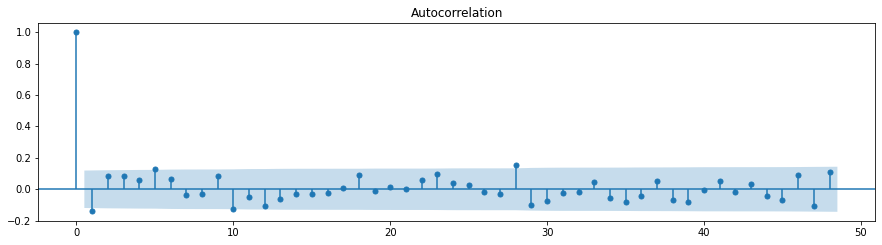

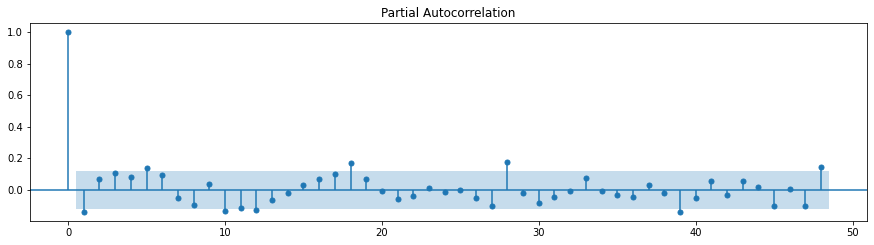

In [68]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag.WAG_box_diff_full.dropna().values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag.WAG_box_diff_full.dropna().values.squeeze(), lags=48, ax=ax)
pylab.show()

Учитывая, что наш ряд имеет сезонность S = 12, начальные приближения для параметров возьмем следующие:
- Q = 0, сезонных лагов со значимой автокорреляцией нет
- q = 5, на самом деле последний несезонный лаг со значимой автокорреляцией имеет номер 28, но рассматривать зависимость на 28 месяцев назад не имеет смысла
- P = 1, номер последнего сезонного лага, при котором значима частичная автокорреляция = 12. Отсюда P = 12 / 12 = 1
- p = 5


In [79]:
Q, q, P, p = 0, 5, 1, 5

c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
ps = range(0, p + 1)
d=1
qs = range(0, q + 1)
Ps = range(0, P + 1)
D=1
Qs = range(0, Q + 1)

In [81]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [83]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wag.WAG_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 50.7 s


Посмотрим на лучшую модель:

In [84]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             WAG_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood                  24.508
Date:                             Thu, 14 Jan 2021   AIC                            -25.016
Time:                                     01:34:18   BIC                             18.209
Sample:                                 01-01-1993   HQIC                            -7.661
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2279      0.525     -0.434      0.664      -1.258       0.802
ar.L2          0.2320      

c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.163094
Критерий Дики-Фуллера: p=0.000000


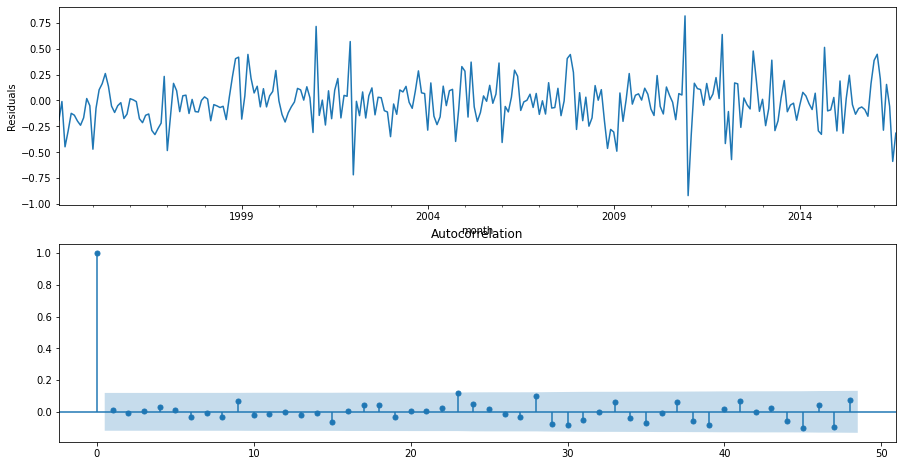

In [85]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


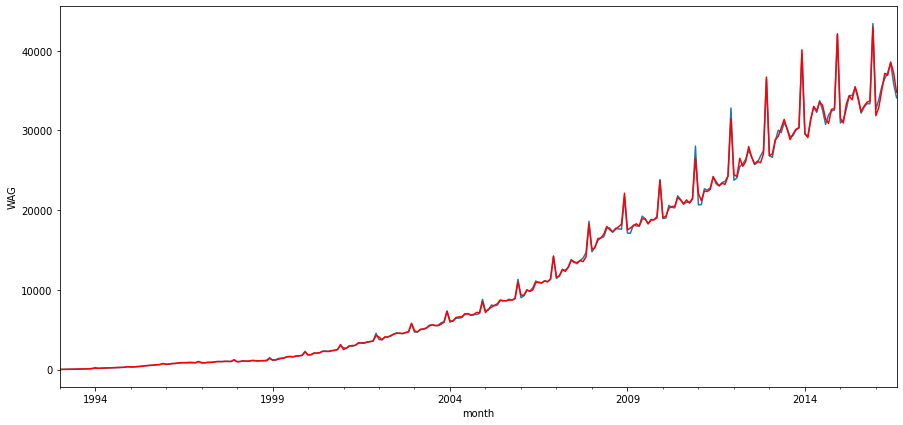

In [86]:
wag['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wag.WAG_C_M.plot()
wag.model.plot(color='r')
plt.ylabel('WAG')
pylab.show()

Получившаяся модель хорошо повторяет имеющиеся данные. Попробуем теперь предсказания

### Прогноз ###

c:\users\skeic\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


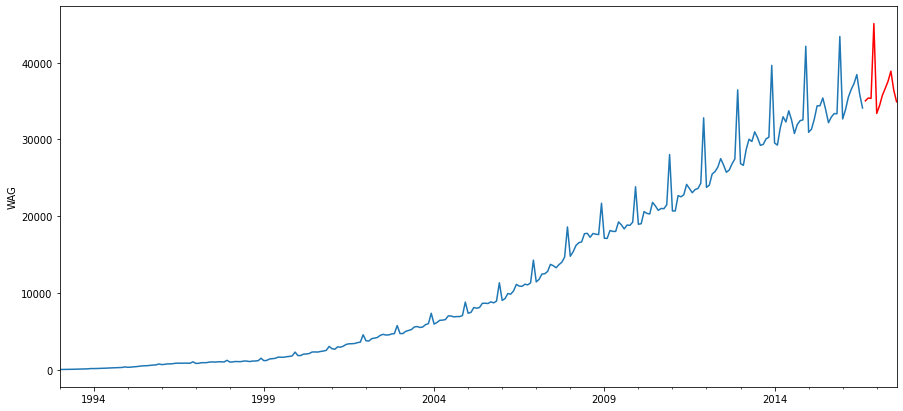

In [100]:
wag2 = wag[['WAG_C_M']]
date_list = [datetime.datetime.strptime("01.09.2016", "%d.%m.%Y") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns = wag2.columns)
wag2 = pd.concat([wag2, future])
wag2['forecast'] = invboxcox(best_model.predict(start=284, end=306), lmbda)

plt.figure(figsize(15,7))
wag2.WAG_C_M.plot()
wag2.forecast.plot(color='r')
plt.ylabel('WAG')
pylab.show()

Получаем неплохой прогноз!